In [1]:
import numpy as np
from scipy.stats import mannwhitneyu, uniform, norm
from matplotlib import pyplot as plt


In [2]:
def test_mann_whitney(first_distr, second_distr, sample_size, significance_level=0.05, n_tests=10000):
    positive_results = 0
    for i in range(n_tests):
        first_sample = first_distr.rvs(sample_size)
        second_sample = second_distr.rvs(sample_size)
        pvalue = mannwhitneyu(first_sample, second_sample, alternative='two-sided').pvalue
        if pvalue < significance_level:
            positive_results += 1
    return positive_results / n_tests

In [3]:
first_distr = uniform(0, 1)
second_distr = uniform(0, 1)
test_mann_whitney(first_distr, second_distr, 10)

0.0431

In [4]:
first_distr = uniform(0, 1)
second_distr = uniform(0, 1)
test_mann_whitney(first_distr, second_distr, 100)

0.0481

In [5]:
first_distr = uniform(0, 1)
second_distr = norm(0, 1)
test_mann_whitney(first_distr, second_distr, 30)

0.69

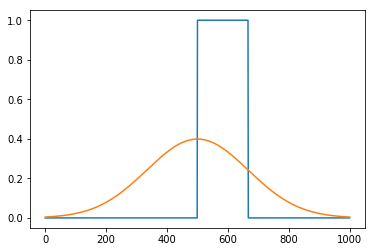

In [6]:
# plot distributions
x = np.linspace(-3, 3, 1001)
plt.plot(first_distr.pdf(x),)
plt.plot(second_distr.pdf(x))
plt.show()

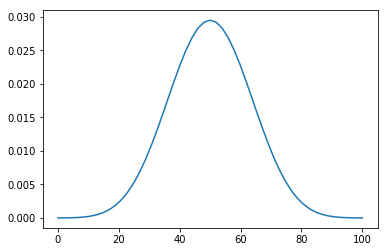

In [7]:
from scipy.special import binom
from itertools import combinations, product
from functools import lru_cache

@lru_cache(None)
def build_u_stat_distribution(first_sample_size, second_sample_size):
    assert first_sample_size <= 10
    assert second_sample_size <= 10
    total_size = first_sample_size + second_sample_size
    u_stat_max_value = first_sample_size * second_sample_size
    distribution = np.zeros(u_stat_max_value + 1, dtype=np.float64)
    for first_sample_ranks in combinations(range(total_size), first_sample_size):
        u_value = 0
        for i, rank in enumerate(first_sample_ranks):
            u_value += rank - i
        distribution[u_value] += 1
    return distribution / distribution.sum()

def exact_two_sided_mann_whitney(first_sample, second_sample):
    u_stat = sum(a > b for a, b in product(first_sample, second_sample))
    mean_value = len(first_sample) * len(second_sample) / 2
    sample_deviation = abs(u_stat - mean_value)
    distribution = build_u_stat_distribution(len(first_sample), len(second_sample))
    pvalue = 0
    for possible_value, prob in enumerate(distribution):
        deviation = abs(possible_value - mean_value)
        if deviation >= sample_deviation:
            pvalue += prob
    return pvalue

def test_exact_mann_whitney(first_distr, second_distr, sample_size, significance_level=0.05, n_tests=10000):
    positive_results = 0
    for i in range(n_tests):
        first_sample = first_distr.rvs(sample_size)
        second_sample = second_distr.rvs(sample_size)
        pvalue = exact_two_sided_mann_whitney(first_sample, second_sample)
        if pvalue < significance_level:
            positive_results += 1
    return positive_results / n_tests



plt.plot(build_u_stat_distribution(10, 10))
plt.show()

In [8]:
test_exact_mann_whitney(uniform(), uniform(), 10)

0.0414

In [9]:
test_exact_mann_whitney(uniform(), uniform(0, 2), 10)

0.4793